## **Optimization: Project 2**

Peyton Lewis, Andrew Gillock, Ruchi Sharma, Aakash Talathi

#### Necessary Imports

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import os.path

import warnings
warnings.filterwarnings('ignore')

#### **Time Limit for Gurobi (MIP) and M Vector Used for IP and MIP**

This time limit variable can be changed to test the program. Additionally, this m vector can be changed to whatever is desired for testing both the IP and MIP programs. Originally, we had the m vector being created dynamically starting from 10 and incrementing by 10 until it reached the end of length of unique stocks in the 2019 (and 2020) returns dataframe with a 5 appended to the front. However, we were instructed to switch m to this static vector that it can easily be changed for the purpose of testing the program later on. 

In [2]:
# Time Limit vector for Gurobi in MIP
time_limit = 10

# M vector for both IP and MIP
m_vector = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

#### Plotting Formatting Styles

In [3]:
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

# Plotting styles for the graphics in the report
# plt.rcParams['axes.titlesize'] = 27
# plt.rcParams['axes.labelsize'] = 23
# plt.rcParams['xtick.labelsize'] = 23
# plt.rcParams['ytick.labelsize'] = 23
# plt.rcParams['legend.fontsize'] = 23

### **1. Read in Data, Compute Daily Returns, Construct Correlation Matrix**

#### Read in Data and Format the Stock Returns

In [4]:
# Read in the Stock Data (2019 and 2020)
stocks2019 = pd.read_csv('stocks2019.csv')
stocks2020 = pd.read_csv('stocks2020.csv')

In [5]:
# Function that formats stock data
# Parameter: dataframe of stock prices
def format_stock_data(df):

    # Rename the first Column as 'Date
    df.rename(columns = {df.columns[0]: 'Date'}, inplace=True)
    #df.rename({'X': 'Date'}, axis = 'columns', inplace=True)

    # Convert the Date Column to a Datetime Object
    df['Date'] = pd.to_datetime(df['Date'])

    # Set index as date and sort by date 
    df.set_index('Date', inplace=True)
    df.sort_index(inplace = True, ascending = True)   

    return df

In [6]:
# Apply the Formatting Function
stocks2019 = format_stock_data(stocks2019)
stocks2020 = format_stock_data(stocks2020)

#### Compute Daily Returns (2019 and 2020)

In [7]:
# Function that computes the daily returns (HPR) of stocks using daily prices
# Parameter: dataframe of stock prices
def compute_returns(stock_df): 

    # Creates list of stocks in df including the Index (NDX)
    list_stocks = stock_df.columns.values.tolist()

    # Initialize empty dataframe
    returns_df = pd.DataFrame()

    # Loop through stocks and compute returns 
    for item in list_stocks:
        returns_df[item] = stock_df[item].pct_change(1)

    # Drop the first row of returns (NaNs)
    returns_df.dropna(inplace=True)

    return returns_df

In [8]:
# Apply the Returns Function to the 2019 and 2020 Data
returns_df = compute_returns(stocks2019)
returns_df_test = compute_returns(stocks2020)

#### Compute Correlation Matrix of Returns (2019 and 2020)

In [9]:
# Function that creates the correlation matrix of stock returns 
# Parameter is a dataframe of returns
def get_correlation_matrix(df):
    return df.corr()

# Correlation Matrix of Returns for 2019
corr_2019 = get_correlation_matrix(returns_df)

# Subset to take out the NDX col and row in the matrix
corr_2019_subset = corr_2019.iloc[1:, 1:]
corr_2019_subset.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,0.317040,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
ALGN,0.216280,0.363370,0.344252,0.332433,1.000000,0.248747,0.250316,0.399281,0.264599,0.328280,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934


### **2. Solve the Stock Selection and Weight Optimization Problem when m = 5. Use 2019 data and compute performance on 2020 data.** 

Objective Function: $$max_{x,y}\sum_{i=1}^{n}\sum_{j=1}^{n}\rho _{ij}\chi_{ij}$$


Constraints: 
$$s.t.\: \sum_{j=1}^{n}y_{i}=m$$
$$\sum_{j=1}^{n}x_{ij}=1 \; for \: i = 1,2,...n$$
$$x_{ij}\leq y_j \; for \: ij = 1,2,...n$$ 
$$\chi_{ij},y_{i} \in \{0,1\}$$

#### Stock Selection (IP)

In [10]:
# Function to Run Gurobi Optimization (Stock Selection IP)
# Parameters: Correlations Matrix of Stock Returns, m stocks to select
def pick_stocks(corr_2019_subset, m_stocks):

    # Objective Function

    # Initialize objective vector to be length of n^2 + n where n is number of stocks in Index
    # There are n^2 x_i,j decision variables, and n y_j decision variables
    obj = np.zeros(len(corr_2019_subset)**2 + len(corr_2019_subset))
    # Loop through the correlation matrix and turn it into a long vector
    for i in range(len(corr_2019_subset)): 
        for j in range(len(corr_2019_subset)): 
            obj[i * len(corr_2019_subset) + j] = corr_2019_subset.iloc[i][j] 

    # Constraints 
    np.set_printoptions(linewidth=np.inf, threshold=np.inf)

    # Number of stocks to select
    m = m_stocks
    

    # A Matrix

    # There as many rows as constraints, which is n^2 + n + 1
    n_rows = len(corr_2019_subset)**2 + len(corr_2019_subset) + 1  
    
    # There are as many colunms as decision variables, which is n^2 + n
    n_cols = len(corr_2019_subset)**2 + len(corr_2019_subset)      
    
    # Initialize the A matrix to be all zeros with the n_rows and n_cols dimensions above
    A = np.zeros((n_rows, n_cols))
    A.shape

    # Direction
    dir = np.array([''] * n_rows)

    # B vector 
    b = np.zeros(n_rows)

    # Only m stocks selected constraint (sum of y_j's = m)
    A[0, -len(corr_2019_subset):] = 1
    dir[0] = '='
    b[0] = m

    # Sum across rows = 1 constraint: Only one in the fund can represent each stock in index
    # n total of these constraints
    for i in range(len(corr_2019_subset)):
        for j in range(len(corr_2019_subset)): 
            A[i + 1, i * len(corr_2019_subset) + j] = 1
        dir[i + 1] = '='
        b[i + 1] = 1


    # x_ij <= y_j constraint: Fund stock can only represent Index stock if it is in fund
    # n^2 total of these constraints
    for i in range(len(corr_2019_subset)):
        for j in range(len(corr_2019_subset)): 
            # starting at the row after n + 1 constraints so far 
            A[i * len(corr_2019_subset) + len(corr_2019_subset) + j + 1, i * len(corr_2019_subset) + j] = 1
            A[i * len(corr_2019_subset) + len(corr_2019_subset) + j + 1, len(corr_2019_subset)**2 + j] = -1
            dir[i * len(corr_2019_subset) + len(corr_2019_subset) + j + 1] = '<'
            b[i * len(corr_2019_subset) + len(corr_2019_subset) + j + 1] = 0  
    

    # Gurobi Model
    stockMod = gp.Model()
    stockMod_x = stockMod.addMVar(len(obj),vtype=['B']*len(obj))   # All decision variables are binary
    stockMod_con = stockMod.addMConstrs(A, stockMod_x, dir, b)
    stockMod.setMObjective(None,obj,0,sense = gp.GRB.MAXIMIZE)

    stockMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    stockMod.optimize()
    result_vec = stockMod_x.x

    # Get the stocks that were chosen (last n decision variables were the y_j's, so show which stocks selected)
    stocks_in = result_vec[-len(corr_2019_subset):]
    stocks_2019 = corr_2019_subset.columns.values.tolist()

    # Add the chosen stocks (where decision variable == 1) to a list, return that list 
    list_stocks_in = []
    for index, item in enumerate(stocks_in): 
        if item == 1: 
            list_stocks_in.append(stocks_2019[index])
    
    return list_stocks_in
    

#### Solve the Stock Selection and Problem when m = 5 

In [11]:
# Apply the Function to the 2019 Data, m = 5
list_stocks_in = pick_stocks(corr_2019_subset, 5)

print()
print('The 5 stocks selected for the fund are: ')
print()
for item in list_stocks_in: 
    print(item)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-09

The 5 stocks selected for the fund are: 

LBTYK
MXIM
MSFT
VRTX
XEL


In [12]:
# Look at the correlation matrix of the stocks selected
corr_2019_subset[list_stocks_in].loc[list_stocks_in]

,LBTYK,MXIM,MSFT,VRTX,XEL
LBTYK,1.000000,0.345558,0.360280,0.127288,0.026509
MXIM,0.345558,1.000000,0.562768,0.297770,0.003016
MSFT,0.360280,0.562768,1.000000,0.396375,0.184241
VRTX,0.127288,0.297770,0.396375,1.000000,0.191667
XEL,0.026509,0.003016,0.184241,0.191667,1.000000


When Gurobi optimized this stock selection problem, it found that the 5 stocks to include in the fund, subject to the constraints, were: LBTYK, MXIM, MSFT, VRTX, and XEL. Because the objective function was to maximize the correlation between the m stocks in the fund and the entire index, it would be expected that the chosen stocks would have low correlations in returns with one another, and would perhaps represent different sectors. This is exactly what we see above as the 5 stocks selected have relatively low correlations of returns with one another, as the maximum correlation between any two stocks is 0.5628 (MXIM and MSFT). 
<br><br>
After some research, it was found that the sectors for each of the 5 chosen stocks are as follows: 

<table>
<tr>
</tr>
<tr>
<th>Stock</th>
<th>Sector</th>
</tr>
<tr>
<td>Liberty Global PLC Class C</td>
<td>Communication Services</td>
</tr>
<tr>
<td>Maxim Integrated Products</td>
<td>Technology</td>
</tr>
<tr>
<td>Microsoft</td>
<td>Technology</td>
</tr>
<tr>
<td>Vertex Pharmaceuticals Incorporated</td>
<td>Healthcare</td>
</tr>
<tr>
<td>Xcel Energy Inc</td>
<td>Utilities</td>
</tr>
</table>

Given this result, it appears that the stocks that Gurobi picked are fairly diverse in terms of sector representation. Other than the overlap between the technology sector, the other stocks represent unique sectors. This analysis will be revisited when the problem is solved for m = 10 stocks, as it is expected that the sectors represented will maintain this diversity.

#### **Calculating Weights (LP)**

Original Objective: 
$$min_{w}\sum_{t=1}^{T}|q_{t} - \sum_{i=1}^{m}w_{i}r_{it}|$$

Updated Objective (Absolute Value Removed):
$$min_{w,y}\sum_{t=1}^{T}y_{t}$$


Updated Constraints: 
$$s.t.\: y_{t}\geq q_{t}-\sum_{i = 1}^{m}w_{i}r_{it}\: for\: t = 1,2,...T$$
$$y_{t}\geq -1 * \left [ q_{t}-\sum_{i = 1}^{m}w_{i}r_{it}\:  \right ] for\: t = 1,2,...T$$
$$\sum_{i=1}^{m}w_{i} = 1$$
$$w_{i} \geq 0$$

#### Weights Optimization (LP)

In [13]:
# Function to Run Optimization: Get Weights
# Parameters: List of stocks selected from Selection function, dataframe of stock returns
def get_weights(list_stocks_in, returns_df): 

    # Compute the number of weights to select
    n_weights = len(list_stocks_in)

    # Chosen Stocks DF
    chosen_stocks_df = returns_df[list_stocks_in]

    # Objective Function

    # Minimizing the sum of the y_1,...y_t continuous decision variables
    # Decision Variables: y_1,...y_t, w_1,...w_n (n = number of stocks selected)
    obj = np.ones(len(returns_df) + n_weights)
    # The n_weights decision variables are zero in obj
    obj[-n_weights:] = 0

    # Constraints
    np.set_printoptions(linewidth=np.inf, threshold=np.inf)

    # Get the number of time periods (t), will need this many y_i decision variables
    n_time_periods = len(returns_df)

    # Will need 2 constraints for every time period as well as constraint of weights summing to 1 (this is n_rows)
    n_rows = 2 * n_time_periods + 1 

    # Number cols is number of decision variables (n_time_periods + n_weights)
    n_cols = n_time_periods + n_weights

    # Create A matrix
    A = np.zeros((n_rows, n_cols))
    dir = np.array(['>'] * n_rows)  # direction is > due to the absolute value trick we are using 
    b = np.zeros(n_rows)

    # Y Constraints (Absolute Value Method)
    for i in range(0, n_time_periods*2, 2):   # will loop over 0 to 2 * n_periods 
        A[i, int(i/2)] = 1                    # put a 1 at the ith row in the y_i position (two rows for each time period)
        A[i, -n_weights:] = chosen_stocks_df.iloc[int(i/2)].values     # change the last n_weights columns to the returns of the stocks selected

        # Two constraints in a row use the same inequality (one does negative)
        A[i + 1, int(i/2)] = 1
        A[i + 1, -n_weights:] = - 1 * chosen_stocks_df.iloc[int(i/2)].values    # same as above, just negative returns now (absolute value trick)

        # Two constraints in a row use the same index return (one does negative)
        b[i] = returns_df.iloc[int(i/2), 0]               # b for first row (of two) is the index return
        b[i + 1] = -1 * returns_df.iloc[int(i/2), 0]      # b for second row (of two) is the negative index return (absolute value trick)

    # Sum of Weights = 1 Constraint
    A[-1, -n_weights:] = 1
    b[-1] = 1
    dir[-1] = '='

    # Gurobi Model
    stockMod2 = gp.Model()
    stockMod2_x = stockMod2.addMVar(len(obj),vtype=['C']*len(obj))   # All decision variables are continuous
    stockMod2_con = stockMod2.addMConstrs(A, stockMod2_x, dir, b)
    stockMod2.setMObjective(None,obj,0,sense = gp.GRB.MINIMIZE)      # MINIMIZE here!

    stockMod2.Params.OutputFlag = 0 # tell gurobi to shut up!!
    stockMod2.optimize()
    result_vec = stockMod2_x.x

    # Extract the Weights
    weights = result_vec[-n_weights:]

    # Print the Weights and the Stock Names as dataframe
    weights_df = pd.DataFrame({'Stocks': list_stocks_in, 'Weights': weights})
    
    # Make the stock the index
    weights_df.set_index('Stocks', inplace=True)
    
    return weights_df

#### Solve the Weight Selection Problem when m = 5 

In [14]:
# Apply Function to the Chosen Stocks (m = 5) in 2019 Data
weights_df = get_weights(list_stocks_in, returns_df)
weights_df

,Weights
Stocks,
LBTYK,0.048862
MXIM,0.210388
MSFT,0.580352
VRTX,0.071190
XEL,0.089208


#### **Performance on 2020 Data (Total Absolute Deviation)**

##### Compute the Total Absolute Deviation

$$Total\: Absolute\: Deviation = |q_t - \sum^N_{i = 1}w_i r_{it}|\:\:for \:t = 1, 2,...T\:$$

In [15]:
# Function that computes that total absolute deviation of the fund from the index
# Parameters: Weights df returned from get_weights function, dataframe of test stock returns
def get_tracking(weights_df, returns_df_test): 

    # Subset the Returns DF to the Chosen Stocks
    returns_df_test_subset = returns_df_test[weights_df.index]

    # Compute the weighted return of the constituent stocks and their optimized weights
    returns_df_test_subset['weighted return'] = np.dot(returns_df_test_subset, weights_df['Weights'])

    # create Index Column 
    returns_df_test_subset['index'] = returns_df_test.iloc[:, 0]

    # Add tracking error column to returns_df_test 
    returns_df_test_subset['total absolute deviation'] = abs(returns_df_test_subset['index'] - returns_df_test_subset['weighted return'])

    return returns_df_test_subset

#### Solve for Total Absolute Deviation when m = 5

In [16]:
# Apply the Function to the 2020 Data (m = 5)
tad_test = get_tracking(weights_df, returns_df_test)
tad_test.head()

,LBTYK,MXIM,MSFT,VRTX,XEL,weighted return,index,total absolute deviation
Date,,,,,,,,
2020-01-03,-0.016204,-0.017299,-0.012452,-0.006699,0.004809,-0.011706,-0.008827,0.002878
2020-01-06,0.015059,-0.018093,0.002585,0.027755,-0.001436,0.000277,0.006211,0.005934
2020-01-07,-0.007881,0.022576,-0.009118,-0.001071,-0.002077,-0.001188,-0.000234,0.000954
2020-01-08,-0.043458,-0.000325,0.015928,0.032620,-0.000961,0.009289,0.007452,0.001837
2020-01-09,-0.024426,0.007308,0.012493,-0.003592,0.002244,0.007539,0.008669,0.001130


In [17]:
print()
print('The total absolute deviation of the fund returns from the index returns in 2020 is:', round(tad_test['total absolute deviation'].sum(), 5))


The total absolute deviation of the fund returns from the index returns in 2020 is: 0.86967


### **3. Solve the Stock Selection and Weight Optimization Problem for various levels of m. Use 2019 data to solve for the weights and compute its performance on 2020 data.** 

In [18]:
# Code Block to hande error if user changes m_vector to values that exceed the number of stocks in the test dataset
# It should create an m vector from 5 to the length of stocks, skipping by 10 and includes the length of stocks too
if max(m_vector) > len(returns_df.columns) - 1:
    m_vector = list(range(10, len(returns_df.columns), 10))
    if (len(returns_df.columns) - 1) % 10 != 0:
        m_vector.append(len(returns_df.columns) - 1)
    if m_vector[0] > 5:
        m_vector.insert(0, 5)
m_vector

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

#### Fund Performance on 2020 Data for (m = 10, 20, 30, 40,...100)

In [19]:
# Loop over the m's and compute tracking error for each 
total_abs_dev_test = []
total_abs_dev_train = []

# Create empty df to store daily weighted returns for each m
weighted_returns_df = pd.DataFrame()

# Using the m vector defined at the top of the notebook 
for i in m_vector:

    # Get the list of stocks selected
    list_stocks_in = pick_stocks(corr_2019_subset, i)

    # Get the weights of the stocks selected=
    weights_df = get_weights(list_stocks_in, returns_df)

    # Get the total absolute deviation of the fund from the index for the test data (2020)
    deviation_test = get_tracking(weights_df, returns_df_test)
    total_abs_dev_test.append(deviation_test['total absolute deviation'].sum())

    # Add the weighted returns of test series to weighted_returns_df
    weighted_returns_df['m = ' + str(i)] = deviation_test['weighted return']

    # Get the total absolute deviation of the fund from the index for the train data (2019)
    deviation_train = get_tracking(weights_df, returns_df)
    total_abs_dev_train.append(deviation_train['total absolute deviation'].sum())

# Dataframe of Total Absolute Deviation and m (test - 2020)
tad_df_test = pd.DataFrame({'m Stocks': m_vector, 'Total Absolute Deviation: 2020': total_abs_dev_test})
tad_df_test.set_index('m Stocks', inplace=True)

# Dataframe of Total Absolute Deviation and m (train - 2019)
tad_df_train = pd.DataFrame({'m Stocks': m_vector, 'Total Absolute Deviation: 2019': total_abs_dev_train})
tad_df_train.set_index('m Stocks', inplace=True)

# Add the Index returns to the weighted returns df
weighted_returns_df['Index'] = returns_df_test.iloc[:, 0]

#### Summary of Out of Sample Fund Performance (2020) and In Sample Fund Performance (2019)

In [20]:
# Merge the train and test dfs on m 
tad_df = pd.merge(tad_df_test, tad_df_train, on='m Stocks')

# Save output to csv
tad_df.to_csv('tad_df.csv')
tad_df

,Total Absolute Deviation: 2020,Total Absolute Deviation: 2019
m Stocks,,
5,0.869670,0.789178
10,0.831317,0.686533
20,0.652338,0.478836
30,0.549085,0.418015
40,0.587312,0.370517
50,0.581148,0.332540
60,0.819424,0.344890
70,0.402497,0.169824
80,0.386431,0.147683


#### Plots of Fund Performance

##### In Sample vs. Out of Sample Fund Performance (Total Absolute Deviation)

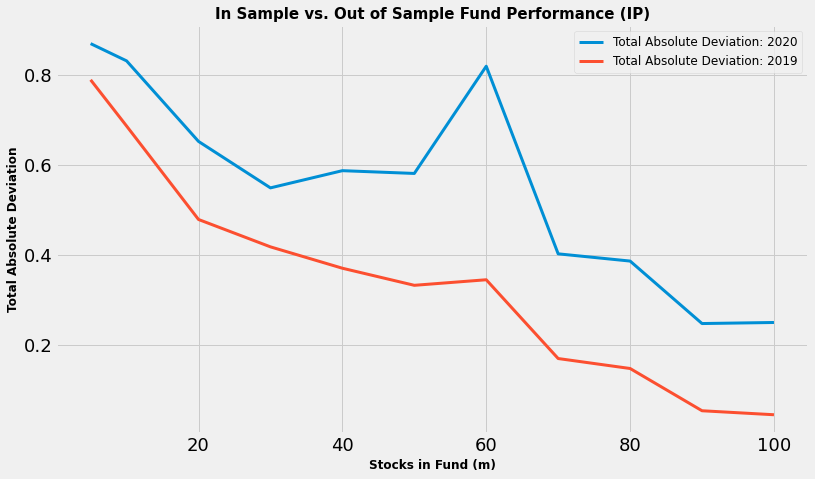

In [21]:
# Plot Total Abs Dev. vs. m (In and Out of Sample Performance)
plt.figure(figsize=(12,7))
plt.plot(tad_df['Total Absolute Deviation: 2020'], label = 'Total Absolute Deviation: 2020', linewidth = 3)
plt.plot(tad_df['Total Absolute Deviation: 2019'], label = 'Total Absolute Deviation: 2019', linewidth = 3)
plt.title('In Sample vs. Out of Sample Fund Performance (IP)', fontsize = 15)
plt.xlabel('Stocks in Fund (m)', fontsize = 12)
plt.ylabel('Total Absolute Deviation', fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

##### Weighted Returns of the Fund and Index over Time (2020) 

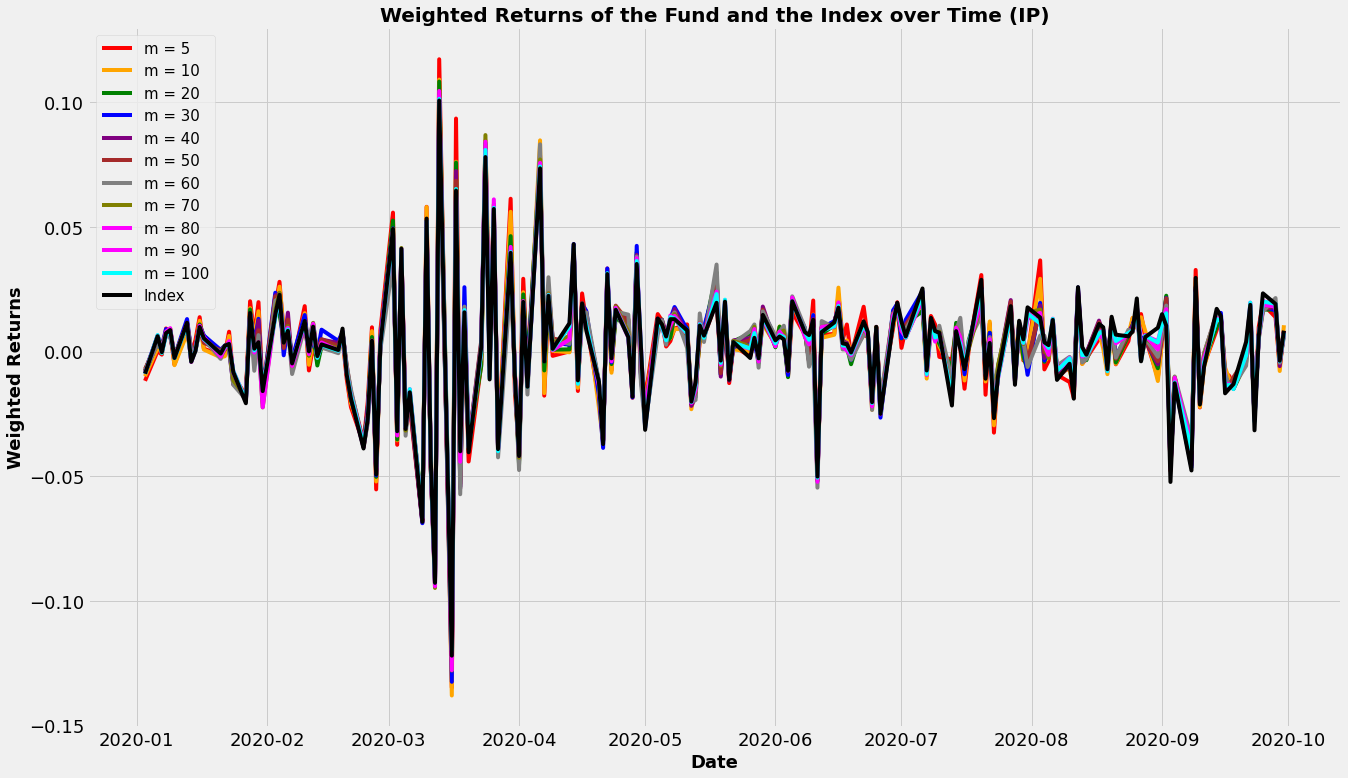

In [22]:
# Plot of the weighted returns for each fund and the index over time  
colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown', 'gray', 'olive', 'magenta', 'magenta', 'cyan', 'black']

plt.figure(figsize=(20,12))

for i, name in enumerate(weighted_returns_df.columns):
    if i == len(weighted_returns_df.columns) -1:
        plt.plot(weighted_returns_df[name], label = name, color = 'black', linewidth = 4)
    else : 
        plt.plot(weighted_returns_df[name], label = name, color = colors[i % len(colors)])
plt.title('Weighted Returns of the Fund and the Index over Time (IP)')
plt.xlabel('Date')
plt.ylabel('Weighted Returns')
plt.legend(fontsize = 15)
plt.show()

##### Cumulative Returns of the Fund and Index over Time (2020) 

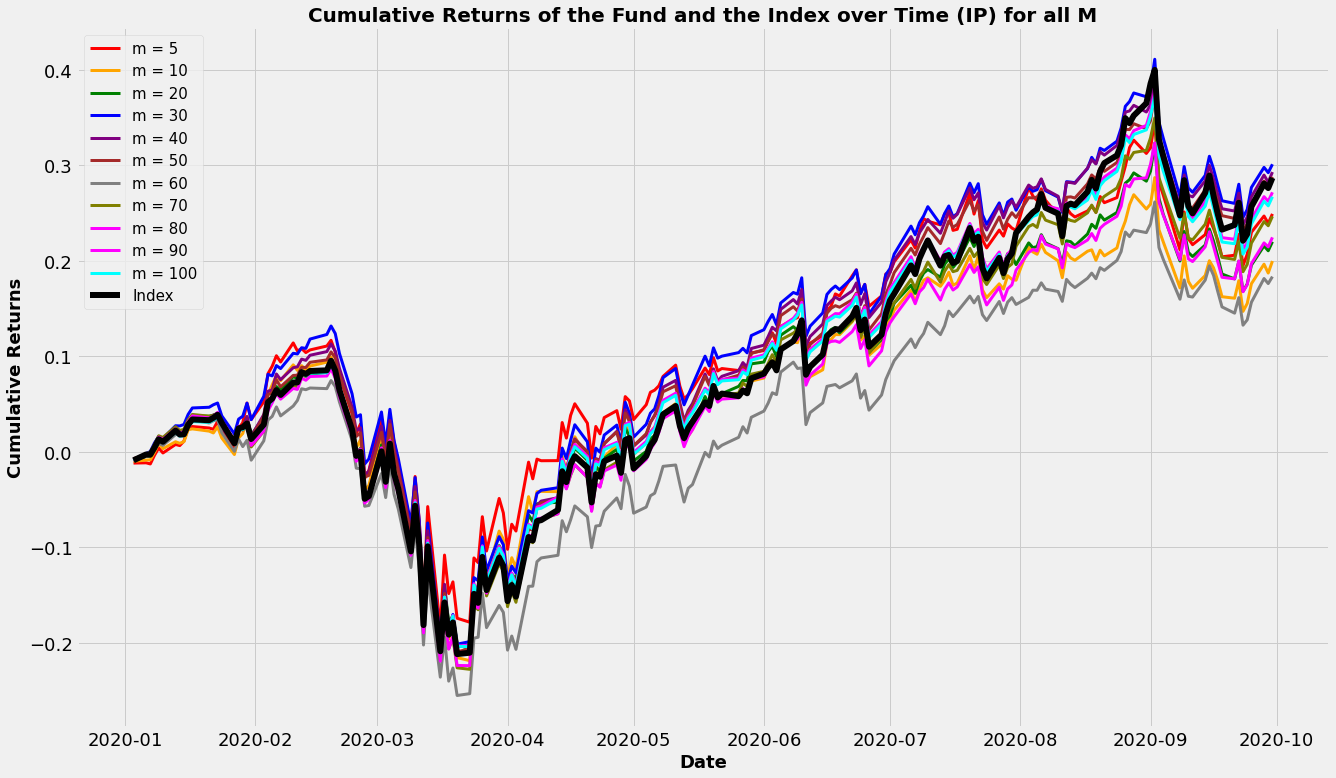

In [23]:
# Plot cumulative returns with unique colors for every m
plt.figure(figsize=(20,12))

# List of unique colors
colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown', 'gray', 'olive', 'magenta', 'magenta', 'cyan', 'black']

# Loop over the columns of weighted_returns_df and plot the cumulative returns
for i in range(len(weighted_returns_df.columns)):
    if i == len(weighted_returns_df.columns) -1:  # Plot the index in black
        plt.plot((1 + weighted_returns_df.iloc[:, i]).cumprod() - 1, label = weighted_returns_df.columns[i], color = "black", linewidth = 6)
    else :
        plt.plot((1 + weighted_returns_df.iloc[:, i]).cumprod() - 1, label = weighted_returns_df.columns[i], color = colors[i % len(colors)], linewidth = 3)

plt.title('Cumulative Returns of the Fund and the Index over Time (IP) for all M')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(fontsize = 15)
plt.show()


##### Cumulative Returns of the Fund and Index over Time (2020) for Subset of M Stocks

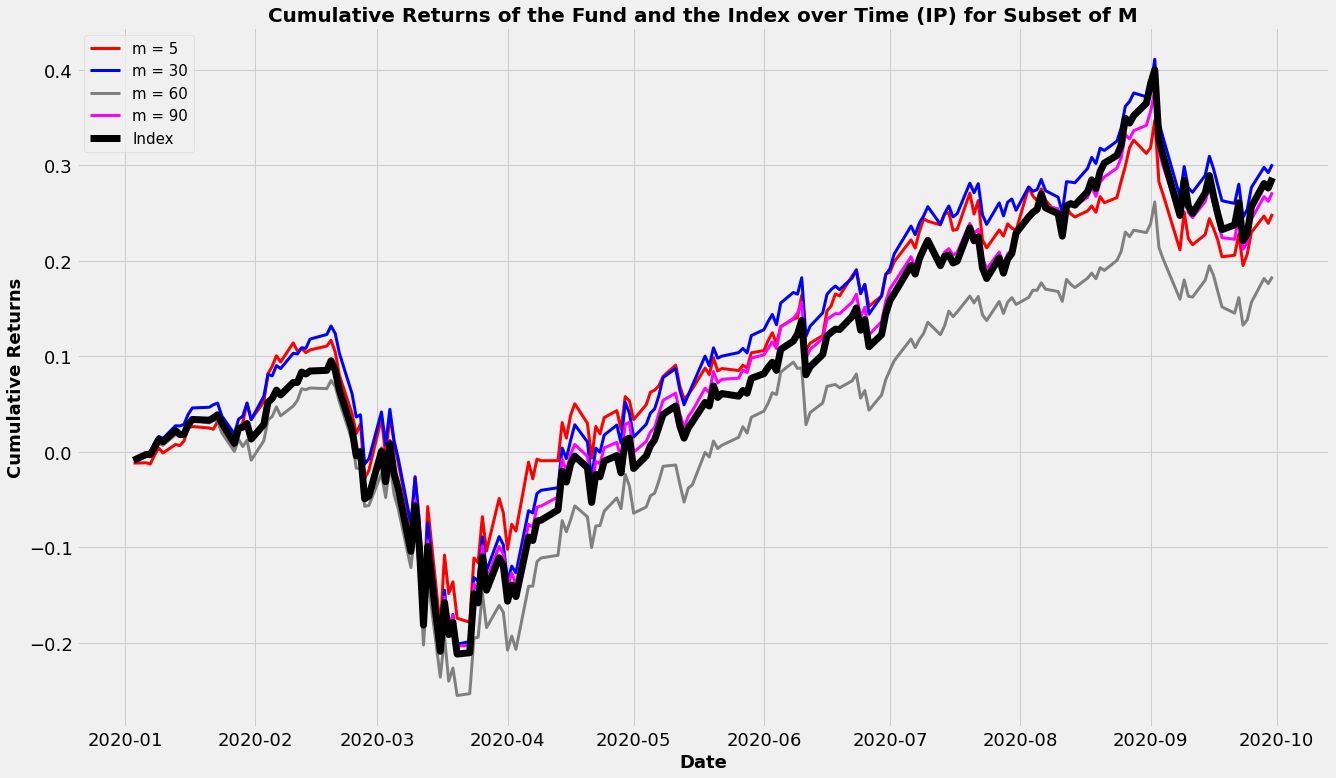

In [24]:
# Plot cumulative returns with unique colors for subset of m's
plt.figure(figsize=(20,12))

# Loop over the columns of weighted_returns_df and plot the cumulative returns
for i in range(len(weighted_returns_df.columns)):
    if i == len(weighted_returns_df.columns) -1:  # Plot the index in black
        plt.plot((1 + weighted_returns_df.iloc[:, i]).cumprod() - 1, label = weighted_returns_df.columns[i], color = 'black', linewidth = 7)
    elif i % 3 == 0:
        plt.plot((1 + weighted_returns_df.iloc[:, i]).cumprod() - 1, label = weighted_returns_df.columns[i], color = colors[i % len(colors)], linewidth = 3)

plt.title('Cumulative Returns of the Fund and the Index over Time (IP) for Subset of M')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(fontsize = 15, loc = 'upper left')
plt.show()


#### **Inspection of the m = 10 Stocks Selection (ONLY relevant for 2019 and 2020 NASDAQ Data)**

**\*\* Disclaimer:** The following analysis was completed for the purpose of looking at the 10 stocks solution our IP found. We chose to include this analysis to try and get insights into the sectors represented and see how our hypothesis held up regarding sector diversity.

Although we have removed the code regarding the IP's stock selection for the case of m = 10, we wanted to report on the 10 stocks that were selected. In our running of the program, the 10 stocks that were selected were: ATVI, ALGN, BKNG, KHC, LBTYK, MXIM, MSFT, ROST, VRTX, and XEL.

Like in the case of 5 stocks explored above, we expected the correlations between the chosen fund stocks to be rather low. When we took a look at the correlation matrix of returns, we found that the maximum correlation between the returns of any two fund stocks does not exceed 0.5628 (again the correlation between MXIM and MSFT). We explore their representative sectors below. <br><br>  

<table>
<tr>
</tr>
<tr>
<th>Stock</th>
<th>Sector</th>
</tr>
<tr>
<td>Activision Blizzard Inc</td>
<td>Consumer Discretionary</td>
</tr>
<tr>
<td>Align Technology, Inc.</td>
<td>Healthcare</td>
</tr>
<tr>
<td>Booking Holdings Inc.</td>
<td>Communication Services</td>
</tr>
<tr>
<td>Kraft Heinz Co</td>
<td>Consumer Staples</td>
</tr>
<tr>
<td>Liberty Global PLC Class C</td>
<td>Communication Services</td>
</tr>
<tr>
<td>Maxim Integrated Products</td>
<td>Technology</td>
</tr>
<tr>
<td>Microsoft</td>
<td>Technology</td>
</tr>
<tr>
<td>Ross Stores, Inc.</td>
<td>Consumer Discretionary</td>
</tr>
<tr>
<td>Vertex Pharmaceuticals Incorporated</td>
<td>Healthcare</td>
</tr>
<tr>
<td>Xcel Energy Inc</td>
<td>Utilities</td>
</tr>
</table>
<br>

Given this result, it appears that the stocks that Gurobi picked are somewhat diverse in terms of sector representation. There were 6 unique sectors selected, and 4 duplicated sectors. We hypothesized that there would be substantial diversification of sectors among the m = 10 solution, as there are 11 financial sectors as defined by the S&P, but this particular solution did not have as much diversity as we were anticipating. A more in depth analysis is completed in the report. <br><br>

### **4. Solve the Problem again with the MIP. Test performance on 2020 data.** 

Objective: 
$$min_{w,y_{t},y_{i}}\sum_{t=1}^{T}y_{t}$$

Constraints: 
$$s.t.\: y_{t}\geq q_{t}-\sum_{i = 1}^{m}w_{i}r_{it}\: for\: t = 1,2,...T$$
$$y_{t}\geq -1 * \left [ q_{t}-\sum_{i = 1}^{m}w_{i}r_{it}\:  \right ] for\: t = 1,2,...T$$
$$w_{i} \leq My_{i}\: for\: i = 1,2,...n$$
$$\sum_{i=1}^{n}y_{i} = m$$
$$\sum_{i=1}^{n}w_{i} = 1$$
$$y_{i} \in \{0,1\}$$
$$w_{i} \geq 0$$

#### MIP (Selection and Weight Optimization)

In [25]:
# Function to Run Optimization: Get Weights
# Parameters: M stocks to select, df of stock returns 
def get_weights_mip(m, returns_df): 

    # Big M Constraint  
    M = 1

    # Take Subset of returns_df removing the Index Return (first column)
    returns_df_subset = returns_df.iloc[:, 1:]

    # compute the number of weights (total # of stocks in returns_df)
    n_weights = len(returns_df.columns) - 1

    # Objective Function

    # Same as before, but now need to add in y_1,...y_n decision variables inserted after the y1,...yT decision variables
    obj = np.ones(len(returns_df) + 2 * n_weights)   # only the y1,...yT decision variables are 1s in obj
    obj[-2 * n_weights:] = 0                         # the y_1,...y_n and w_1,..w_n decision variables are 0s in obj

    # Constraints
    np.set_printoptions(linewidth=np.inf, threshold=np.inf)

    # Getting the Dimensions of A matrix
    n_time_periods = len(returns_df)    # used for y_1,...y_T decision variables 
    n_rows = 2 * n_time_periods + 1 + n_weights + 1    # same as before, but new n_weights is number of M constraints, 1 is for sum weights = m constraint
    n_cols = n_time_periods + 2 * n_weights            # same as before, but now n_weights more decision variables (y_1,...y_n binaries)

    # Creating the A matrix 
    A = np.zeros((n_rows, n_cols))
    dir = np.array(['>'] * n_rows)    # last n_weights of them will be < , final will be = (overrride later)
    b = np.zeros(n_rows)

    # Y Time Period Constraints (Absolute Value Method)
    # These are same as previous weight function, and cover rows 0 to 2 * n_time_periods (0 - 499 in this case)
    for i in range(0, n_time_periods*2, 2): 
        A[i, int(i/2)] = 1                                              # puts a 1 in the position of the y1,...yT decision variable
        A[i, -n_weights:] = returns_df_subset.iloc[int(i/2)].values     # puts in weights decision variables slot the daily returns 

        # Two constraints in a row use the same inequality (one does negative)
        A[i + 1, int(i/2)] = 1                                                  # two rows in a row for each time period (absolute value method)
        A[i + 1, -n_weights:] = - 1 * returns_df_subset.iloc[int(i/2)].values   # flips to negative returns (absolute value trick)

        # Two constraints in a row use the same index return (one does negative)
        b[i] = returns_df.iloc[int(i/2), 0]                             # index return for that time period                  
        b[i + 1] = -1 * returns_df.iloc[int(i/2), 0]                    # -1 * index return for that time period (absolute value trick)

    # Big M Constraints (will have n_weights of them)
    # for each stock, equation is w_i <= M * y_i --> w_i - M * y_i <= 0
    A[n_time_periods * 2 + 1 : n_rows - 1, -2 * n_weights: -n_weights] = np.eye(n_weights) * -M  # puts in -M for y_1,...y_n decision variables 
    #                                                                                            (one row for each stock)
    A[n_time_periods * 2 + 1 : n_rows - 1, -1 * n_weights:] = np.eye(n_weights)                  # puts in 1 for w_1,...w_n decision variables 
    #                                                                                            (one row for each stock)
    b[n_time_periods * 2 + 1 : n_rows - 1] = 0                          # puts in 0 for the b vector (one row for each stock)
    dir[n_time_periods * 2 + 1 : n_rows - 1] = '<'                      # puts in < for the direction vector (one row for each stock)

    # Binary Y Constraints (sum to m)
    # y_1 + y_2 + ... + y_n = m
    A[-2, -2 * n_weights: -n_weights] = 1   # should fill in -200 to -100 index positions (all the y_1,...y_n binary decision variables) when n_weights = 100)
    b[-2] = m                               # puts in m for the b vector, so sum of binary y's is m (m stocks selected)
    dir[-2] = '='                           # puts in = for the direction vector, so sum of binary y's is m (m stocks selected)

    # Sum of Weights = 1 Constraint
    # w_1 + w_2 + ... + w_n = 1
    A[-1, -n_weights:] = 1
    b[-1] = 1
    dir[-1] = '='


    # Gurobi Model
    stockMod2 = gp.Model()
    stockMod2.setParam('TimeLimit', time_limit)
    stockMod2_x = stockMod2.addMVar(len(obj),vtype=['C']*len(returns_df) + ['B'] * n_weights + ['C'] * n_weights)  # y_1,...y_T are continuous, y_1,...y_n are binary, w_1,...w_n are continuous
    stockMod2_con = stockMod2.addMConstrs(A, stockMod2_x, dir, b)
    stockMod2.setMObjective(None,obj,0,sense = gp.GRB.MINIMIZE)    # MINIMIZE

    stockMod2.Params.OutputFlag = 0 # tell gurobi to shut up!!
    stockMod2.optimize()
    result_vec = stockMod2_x.x

    # Extract the Weights
    weights = result_vec[-n_weights:]

    # Make the Weights and the Stock Names as dataframe
    weights_df = pd.DataFrame({'Stocks': returns_df_subset.columns, 'Weights': weights})

    # make stock the index
    weights_df.set_index('Stocks', inplace=True)
    
    return weights_df

#### Measure Fund Performance on 2019 and 2020 Data

**Disclaimer:** This program will tell the user "File exists. Pulling csv for m = i" if the csv file for the given m already exists. This is to save time when running the program and to not have to run it with a time limit of 3600 every time. When the notebook is submitted, it will be without the csv files, so the program will run fully and will tell the user as it is running: "File does not exist. Computing weights for m = i."

$$Total\: Absolute\: Deviation = |q_t - \sum^N_{i = 1}w_i r_{it}|\:\:for \:t = 1, 2,...T\:$$

In [26]:
# Loop over the m's and compute tracking error for each 
total_abs_dev_test = []
total_abs_dev_train = []

# Create empty df to store daily weighted returns for each m
weighted_returns_df2 = pd.DataFrame()

for i in m_vector: 
    file_exists = os.path.exists('mip_' + str(i) + '.csv')

    if file_exists == True: 
        print('File exists. Pulling csv for m = ' + str(i) + '.')
        weights_df = pd.read_csv('mip_' + str(i) + '.csv', index_col = 0)
    else: 
        print('File does not exist. Computing weights for m = ' + str(i) + '.')
        weights_df = get_weights_mip(i, returns_df)
        #weights_df.to_csv('mip_' + str(i) + '.csv')
    

    # Compute test TAD
    deviation_test = get_tracking(weights_df, returns_df_test)
    total_abs_dev_test.append(deviation_test['total absolute deviation'].sum())

    # Add the weighted returns of test series to weighted_returns_df
    weighted_returns_df2['m = ' + str(i)] = deviation_test['weighted return']

    # Compute train TAD
    deviation_train = get_tracking(weights_df, returns_df)
    total_abs_dev_train.append(deviation_train['total absolute deviation'].sum())

# Dataframe of Total Absolute Deviation and m (test - 2020)
tad_df_test = pd.DataFrame({'m Stocks': m_vector, 'Total Absolute Deviation: 2020': total_abs_dev_test})
tad_df_test.set_index('m Stocks', inplace=True)

# Dataframe of Total Absolute Deviation and m (train - 2019)
tad_df_train = pd.DataFrame({'m Stocks': m_vector, 'Total Absolute Deviation: 2019': total_abs_dev_train})
tad_df_train.set_index('m Stocks', inplace=True)

# Add the Index returns to the weighted returns df
weighted_returns_df2['Index'] = returns_df_test.iloc[:, 0]


File exists. Pulling csv for m = 5.
File exists. Pulling csv for m = 10.
File exists. Pulling csv for m = 20.
File exists. Pulling csv for m = 30.
File exists. Pulling csv for m = 40.
File exists. Pulling csv for m = 50.
File exists. Pulling csv for m = 60.
File exists. Pulling csv for m = 70.
File exists. Pulling csv for m = 80.
File exists. Pulling csv for m = 90.
File exists. Pulling csv for m = 100.


#### Fund Performance in 2020 (Out of Sample) and 2019 (In Sample)

In [27]:
# Merging the test and train TAD dataframes
tad_df_mip = pd.merge(tad_df_test, tad_df_train, on='m Stocks')
tad_df_mip.to_csv('tad_df_mip.csv')
tad_df_mip

,Total Absolute Deviation: 2020,Total Absolute Deviation: 2019
m Stocks,,
5,0.591398,0.499259
10,0.548939,0.290137
20,0.396847,0.156564
30,0.301516,0.108868
40,0.281295,0.078577
50,0.281195,0.064904
60,0.260915,0.052830
70,0.258282,0.048553
80,0.249828,0.046996


#### Displaying the MIP Program Results for m = 5

In [28]:
# This will pull the csv if it exists, otherwise it will compute the weights and return the dataframe
test_m = 5
file5_exists = os.path.exists('mip_5.csv')

if file5_exists == True:
    print('File exists. Pulling csv for m = ' + str(test_m) + '.')
    weights_df5 = pd.read_csv('mip_' + str(test_m) + '.csv', index_col = 0)
else: 
    print('File does not exist. Computing weights for m = ' + str(test_m) + '.')
    weights_df5 = get_weights_mip(test_m, returns_df)

# weights where nonzero
weights_df5[weights_df5['Weights'] > 0]


File exists. Pulling csv for m = 5.


,Weights
Stocks,
AMZN,0.250123
ADI,0.113758
AAPL,0.191692
MSFT,0.289869
MDLZ,0.154558


In [29]:
# Compute the TAD for m = 5 (MIP)
deviation_test5 = get_tracking(weights_df5, returns_df_test)
deviation_train5 = get_tracking(weights_df5, returns_df)
print()
print("Total Absolute Deviation (m = 5) in 2020: ", round(deviation_test5['total absolute deviation'].sum(), 6))
print()
print("Total Absolute Deviation (m = 5) in 2019: ", round(deviation_train5['total absolute deviation'].sum(), 6))


Total Absolute Deviation (m = 5) in 2020:  0.591398

Total Absolute Deviation (m = 5) in 2019:  0.499259


#### **Inspection of m = 10 stocks selection for MIP (ONLY relevant for 2019 & 2020 NASDAQ Data)**

**\*\* Disclaimer:** The following analysis was completed for the purpose of looking at the 10 stocks solution our MIP found. We chose to include this analysis to try and get insights into the sectors represented and see how our hypothesis held up regarding sector diversity.

We completed this analysis for the purpose of comparing the selection algorithms for the IP/LP and the MIP. We chose to include this analysis to again try and get insights into the sectors represented and see how our hypothesis held up regarding sector diversity. The 10 stocks selected with the time limit = 3600 were GOOGL, AMZN, AMGN, AAPL, FB, INTC, MXIM, MSFT, PAYX, and WBA. We again looked at the inter-stock correlations and found that interestingly, the highest correlation of returns was between MSFT and PAYX (0.6883), whose stock represents two different industries: Technology and Industrials. After performing a sector analysis on these stocks, we found that a similar result arose as a majority of tech stocks were selected, and a fairly diverse set of sectors were represented. The full analysis of this portion is included in the report. <br><br>

#### Plot of In Sample (2019) vs. Out of Sample (2020) Fund Performance

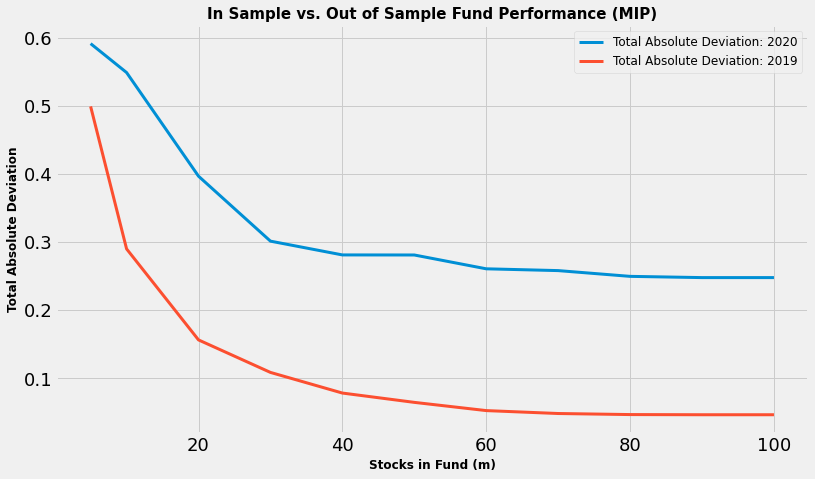

In [30]:
# Plot Total Abs Dev. vs. m (In and Out of Sample Performance)
plt.figure(figsize=(12,7))
plt.plot(tad_df_mip['Total Absolute Deviation: 2020'], label = 'Total Absolute Deviation: 2020', linewidth = 3)
plt.plot(tad_df_mip['Total Absolute Deviation: 2019'], label = 'Total Absolute Deviation: 2019', linewidth = 3)
plt.title('In Sample vs. Out of Sample Fund Performance (MIP)', fontsize=15)
plt.xlabel('Stocks in Fund (m)', fontsize=12)
plt.ylabel('Total Absolute Deviation', fontsize=12)
plt.legend(fontsize=12)
plt.show()

#### Plots of Index Returns and Fund Returns over Time (2020)

##### Weighted Returns of the Fund and Index over Time (2020)

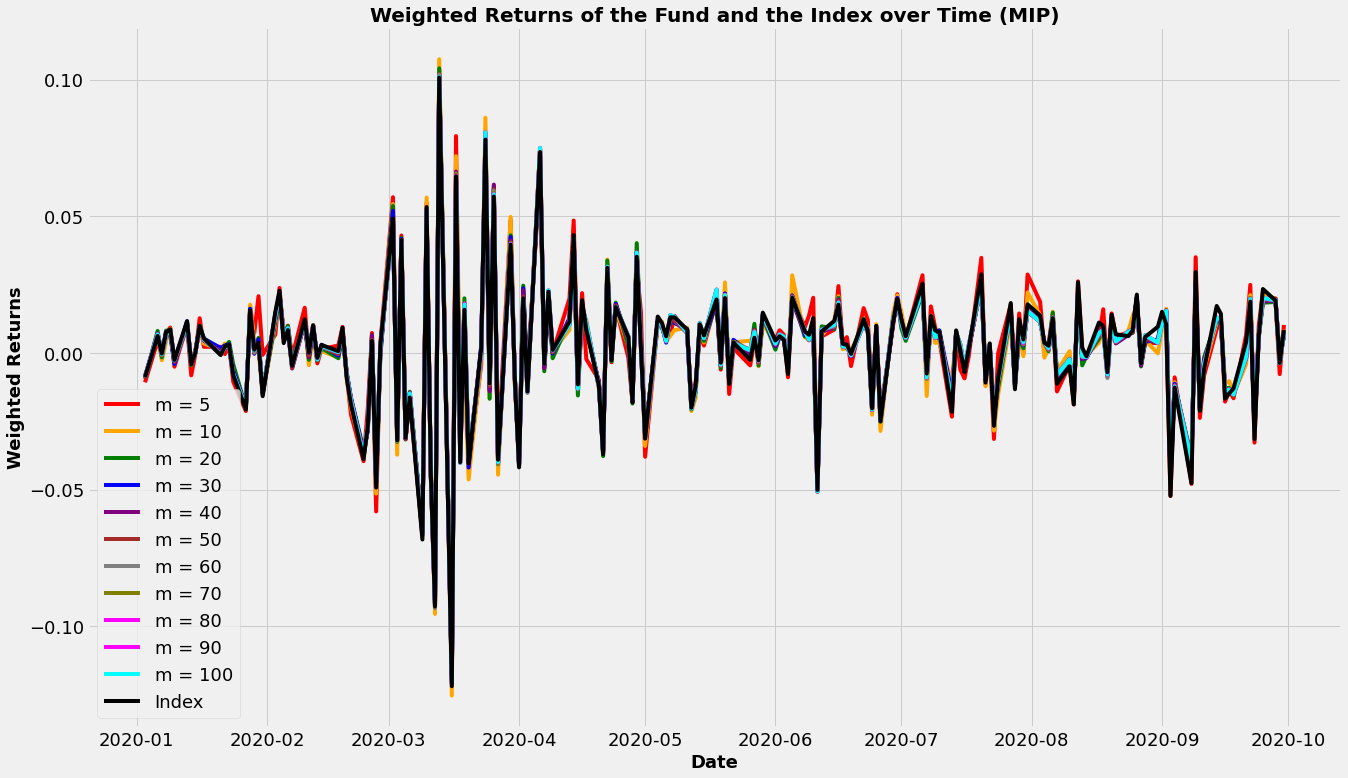

In [31]:
colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown', 'gray', 'olive', 'magenta', 'magenta', 'cyan', 'black']

plt.figure(figsize=(20,12))

# Plot of the weighted returns for each fund and the index over time  
for i, name in enumerate(weighted_returns_df2.columns):
    if i == len(weighted_returns_df2.columns) -1:
        plt.plot(weighted_returns_df2[name], label = name, color = 'black', linewidth = 4)
    else : 
        plt.plot(weighted_returns_df2[name], label = name, color = colors[i % len(colors)])
plt.title('Weighted Returns of the Fund and the Index over Time (MIP)')
plt.xlabel('Date')
plt.ylabel('Weighted Returns')
plt.legend(loc = 'lower left')
plt.show()


##### Cumulative Returns of the Fund and Index over Time (2020) 

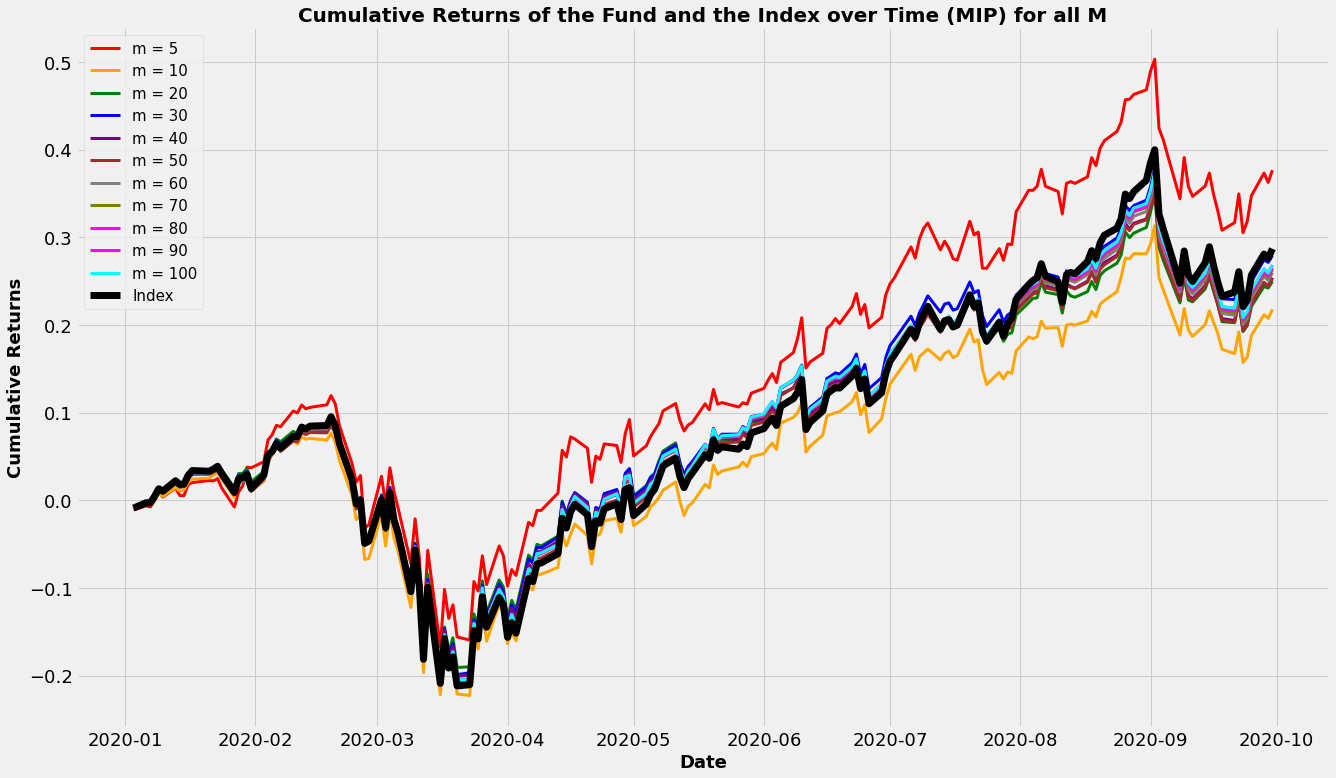

In [32]:
# Plot cumulative returns with unique colors for every m
plt.figure(figsize=(20,12))

# List of unique colors
colors = ['red', 'orange', 'green', 'blue', 'purple', 'brown', 'gray', 'olive', 'magenta', 'magenta', 'cyan', 'black']

# Loop over the columns of weighted_returns_df and plot the cumulative returns
for i in range(len(weighted_returns_df2.columns)):
    if i == len(weighted_returns_df2.columns) -1:  # Plot the index in black
        plt.plot((1 + weighted_returns_df2.iloc[:, i]).cumprod() - 1, label = weighted_returns_df2.columns[i], color = "black", linewidth = 7)
    else :
        plt.plot((1 + weighted_returns_df2.iloc[:, i]).cumprod() - 1, label = weighted_returns_df2.columns[i], color = colors[i % len(colors)], linewidth = 3)

plt.title('Cumulative Returns of the Fund and the Index over Time (MIP) for all M')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(fontsize = 15)
plt.show()


##### Cumulative Returns of the Fund and Index over Time (2020) for Subset of M Stocks

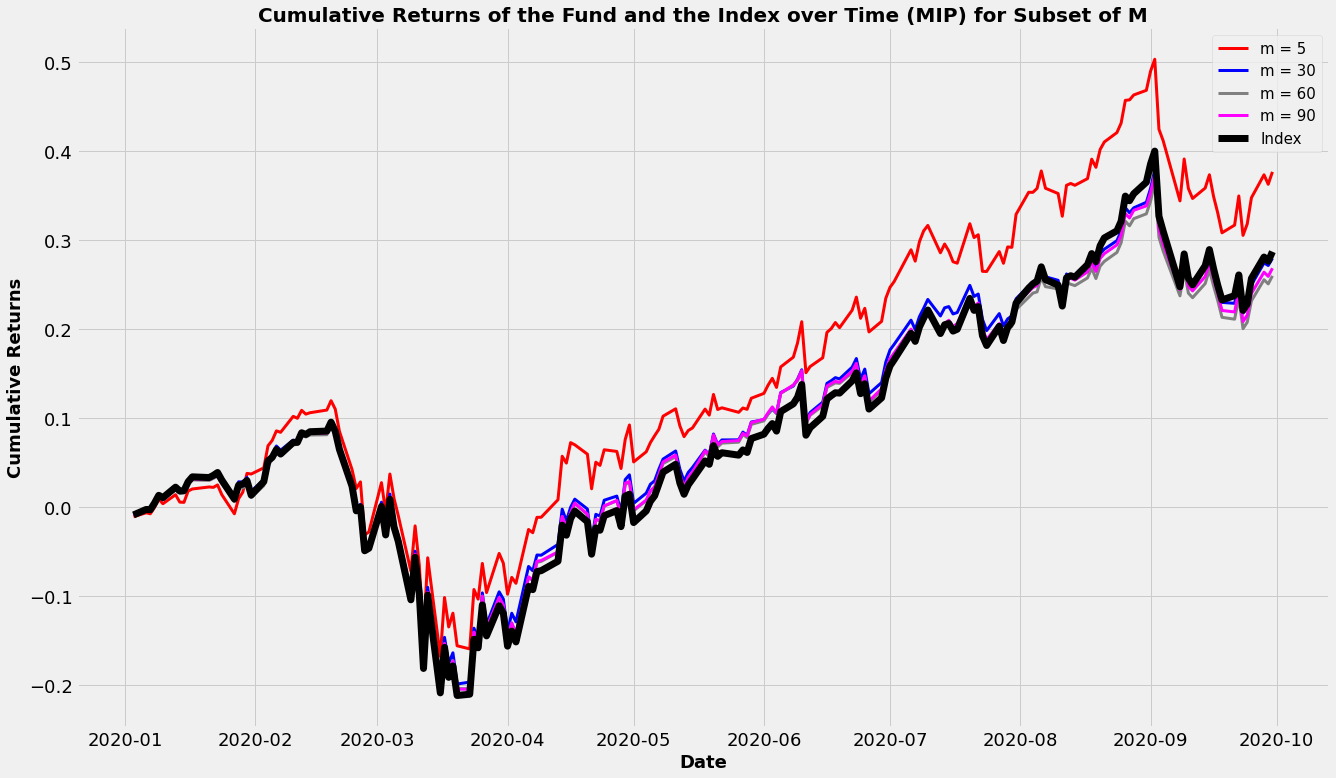

In [33]:
# Plot cumulative returns with unique colors for subset of m's
plt.figure(figsize=(20,12))

# Loop over the columns of weighted_returns_df and plot the cumulative returns
for i in range(len(weighted_returns_df2.columns)):
    if i == len(weighted_returns_df2.columns) -1:  # Plot the index in black
        plt.plot((1 + weighted_returns_df2.iloc[:, i]).cumprod() - 1, label = weighted_returns_df2.columns[i], color = 'black', linewidth = 7)
    elif i % 3 == 0:
        plt.plot((1 + weighted_returns_df2.iloc[:, i]).cumprod() - 1, label = weighted_returns_df2.columns[i], color = colors[i % len(colors)], linewidth = 3)

plt.title('Cumulative Returns of the Fund and the Index over Time (MIP) for Subset of M')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(fontsize = 15)
plt.show()
